In [83]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [84]:
def calculate_hit_rate(summarised_data, pairwise_data):
    summarised_data = np.array(summarised_data, dtype=[('model', 'U20'), ('value', 'i4')])
    pairwise_data = np.array(pairwise_data, dtype=[('model_pair', 'U20'), ('value', 'i4')])

    model_dict = {model: value for model, value in summarised_data}
    
    ai_models = np.array([model.split('-')[-1] for model in pairwise_data['model_pair']])
    divisors = np.vectorize(model_dict.get)(ai_models)

    # Perform the division on array2's values by the corresponding divisors
    result_values = pairwise_data['value'] / divisors

    # Combine model_pair and result_values into a structured array for the result
    result = np.array(list(zip(pairwise_data['model_pair'], result_values)),
                    dtype=[('model_pair', 'U20'), ('divided_value', 'f4')])
    
    return result

In [85]:
# Hit rate for all extracted papers

pairwise_data = []
summarised_data = []

# Define the path to the bigger parent folder
bigger_parent_folder = "./extracted"

# Dictionary to store data for each parent folder
extracted_data = {}

# Walk through only directories directly under the bigger parent folder
for parent_folder in os.listdir(bigger_parent_folder):
    parent_folder_path = os.path.join(bigger_parent_folder, parent_folder)
    
    # Ensure we're only processing directories
    if os.path.isdir(parent_folder_path):
        # Initialize dictionary entry for each parent folder
        extracted_data[parent_folder] = {'pairwise': [], 'summarised': []}
        
        # Check if 'pairwise' folder exists in the current parent folder
        pairwise_folder_path = os.path.join(parent_folder_path, 'pairwise')
        if os.path.isdir(pairwise_folder_path):
            for filename in os.listdir(pairwise_folder_path):
                if filename.endswith('.json'):
                    filepath = os.path.join(pairwise_folder_path, filename)
                    with open(filepath) as f:
                        data = json.load(f)
                        df = pd.DataFrame(data)
                        extracted_data[parent_folder]['pairwise'].append(
                            (filename.replace('.json', ''), len(df.axes[1]))
                        )
        
        # Check if 'summarised' folder exists in the current parent folder
        summarised_folder_path = os.path.join(parent_folder_path, 'summarised')
        if os.path.isdir(summarised_folder_path):
            for filename in os.listdir(summarised_folder_path):
                if filename.endswith('.json'):
                    filepath = os.path.join(summarised_folder_path, filename)
                    with open(filepath) as f:
                        data = json.load(f)
                        df = pd.DataFrame(data)
                        extracted_data[parent_folder]['summarised'].append(
                            (filename.replace('.json', ''), len(df.axes[1]))
                        )

# Output the collected data for each parent folder
print(extracted_data['exploring_extreme_parameter_compression_for_pre-trained_language_models'])

{'pairwise': [('review3-gpt4', 2), ('review1-gemini_pro', 1), ('review2-gpt4', 1), ('review1-gpt4', 0), ('review3-gemini_pro', 2), ('review2-gemini_pro', 2)], 'summarised': [('gemini_pro', 3), ('review1', 2), ('claude_opus', 4), ('review2', 4), ('review3', 5), ('gpt4', 2)]}


In [86]:
paper_hit_rates = {}

for paper in extracted_data:
    if extracted_data[paper]['summarised'] and extracted_data[paper]['pairwise']:
        hit_rates = calculate_hit_rate(extracted_data[paper]['summarised'], extracted_data[paper]['pairwise'])
        paper_hit_rates[paper] = hit_rates
    else:
        continue

paper_hit_rates

{'exploring_extreme_parameter_compression_for_pre-trained_language_models': array([('review3-gpt4', 1.        ), ('review1-gemini_pro', 0.33333334),
        ('review2-gpt4', 0.5       ), ('review1-gpt4', 0.        ),
        ('review3-gemini_pro', 0.6666667 ),
        ('review2-gemini_pro', 0.6666667 )],
       dtype=[('model_pair', '<U20'), ('divided_value', '<f4')])}

In [ ]:
def plot_average_hit_rate(data, model_key):
    # Extract the model pairs and values
    records = data[model_key]
    
    # Separate hit rates for gemini_pro and gpt4
    gemini_pro_values = [record['divided_value'] for record in records if 'gemini_pro' in record['model_pair']]
    gpt4_values = [record['divided_value'] for record in records if 'gpt4' in record['model_pair']]
    
    # Calculate average hit rates
    avg_gemini_pro = np.mean(gemini_pro_values) if gemini_pro_values else 0
    avg_gpt4 = np.mean(gpt4_values) if gpt4_values else 0
    
    # Plot bar graph
    models = ['gemini_pro', 'gpt4']
    averages = [avg_gemini_pro, avg_gpt4]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, averages, color=['blue', 'green'])
    plt.xlabel('AI Model')
    plt.ylabel('Average Hit Rate')
    plt.title(f'Average Hit Rate for Reviews - {model_key}')
    plt.ylim(0, 1)  # assuming hit rate is between 0 and 1
    
    # Display the average values on the bars
    for i, avg in enumerate(averages):
        plt.text(i, avg + 0.05, f"{avg:.2f}", ha='center', fontsize=12)
    
    plt.show()

def plot_average_hit_rate_across_papers(data):
    # Lists to aggregate hit rates for gemini_pro and gpt4 across all papers
    gemini_pro_values = []
    gpt4_values = []
    
    # Iterate over each paper's data
    for _, records in data.items():
        # Collect values for gemini_pro and gpt4
        gemini_pro_values.extend([record['divided_value'] for record in records if 'gemini_pro' in record['model_pair']])
        gpt4_values.extend([record['divided_value'] for record in records if 'gpt4' in record['model_pair']])
    
    # Calculate average hit rates across all papers
    avg_gemini_pro = np.mean(gemini_pro_values) * 100 if gemini_pro_values else 0  # Multiply by 100
    avg_gpt4 = np.mean(gpt4_values) * 100 if gpt4_values else 0  # Multiply by 100
    
    # Plot bar graph
    models = ['gemini_pro', 'gpt4']
    averages = [avg_gemini_pro, avg_gpt4]
    
    plt.figure(figsize=(8, 5))
    plt.bar(models, averages, color=['blue', 'green'])
    plt.xlabel('AI Model')
    plt.ylabel('Hit Rate (%)')
    plt.title('Retrospective overlap analysis of ML models across all papers')
    plt.ylim(0, 100)  # y-axis from 0 to 100
    
    # Display the average values on the bars
    for i, avg in enumerate(averages):
        plt.text(i, avg + 2, f"{avg:.2f}%", ha='center', fontsize=12)
    
    plt.show()


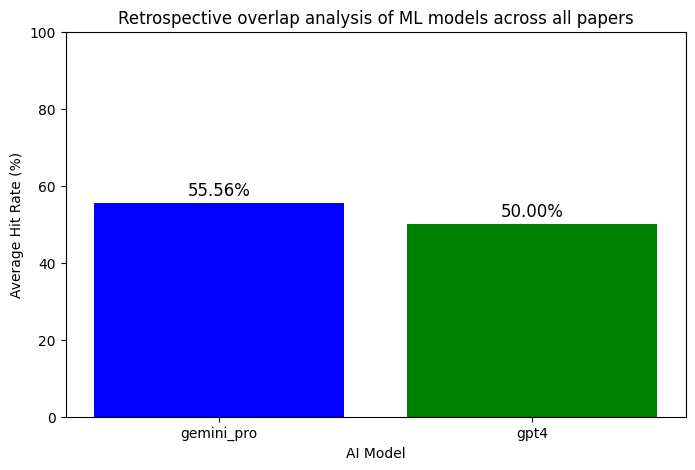

In [88]:
plot_average_hit_rate_across_papers(paper_hit_rates)